# ProbabilityV0

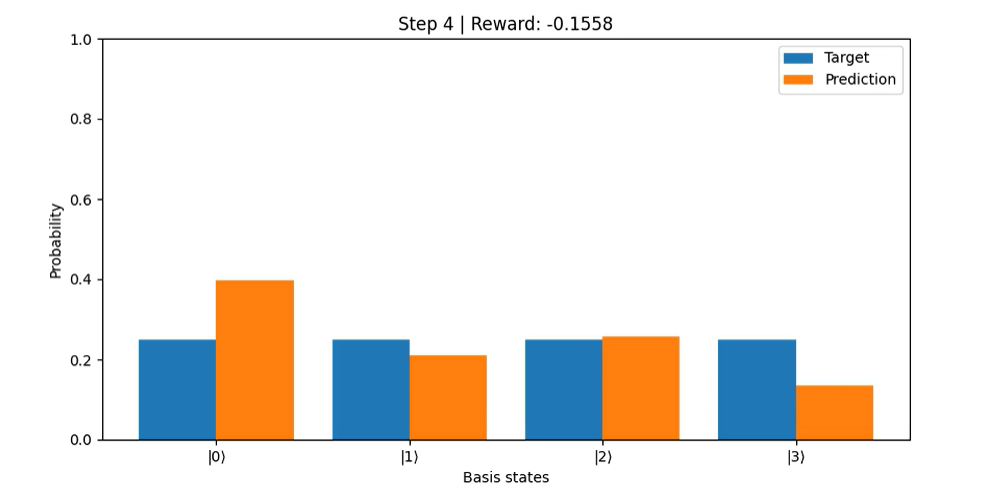

## Description

Reinforcement learning environment for training parameterized quantum circuits 
to approximate a target probability distribution over computational basis states.
It is based on the `QuantumEnv` base class.

The goal of `ProbabilityV0` is to optimize variational quantum circuits such that 
the measured probability distribution of outcomes matches a given target 
distribution. This is useful in tasks like quantum compilation, quantum generative 
modeling, and distribution learning.

## Environment Dynamics
- **State (observation):**
    The current probability distribution over `2**n_qubits` basis states obtained 
    from the quantum circuit.

- **Action:**
    A continuous vector of parameter updates (`Box(low=-0.1, high=0.1, shape=(n_params,)`), 
    which perturbs the trainable parameters of the ansatz.

- **Reward:**
    Defined as the *negative* of a weighted cost combining:
    - KL divergence between the target distribution and the circuit's output.
    - L2 distance between the target and circuit distributions.
    The weighting is controlled by `alpha` (for KL vs. L2) and `beta` (step penalty).

- **Episode Termination:**
    - If the reward is below the specified tolerance.
    - If the number of steps reaches `max_steps`.


**Key Parameters**
-----------------
- `n_qubits (int)`: Number of qubits in the circuit.
- `target_distribution (np.ndarray)`: Target probability distribution (must sum to 1).
- `ansatz (callable, optional)`: Custom circuit ansatz. Defaults to a simple 
    layer of RY rotations if not provided.
- `max_steps (int, default=100)`: Maximum steps per episode.
- `tolerance (float, default=-1e3)`: Reward threshold for termination.
- `alpha (float, default=0.5)`: Weight between KL divergence and L2 error.
- `beta (float, default=0.01)`: Penalty weight for step count.
- `ffmpeg (bool, default=False)`: If `True`, uses FFmpeg for saving animations; otherwise uses Pillow (GIF).

**Visualization**
----------------
- `render()`: Creates an animation showing the evolution of the learned 
    distribution and corresponding rewards across training.


**Applications**
----------------
- Distribution learning with quantum circuits.
- Testing expressivity of variational ansätze.
- Benchmarking optimization of quantum neural networks.


Step 0: Reward = -1.0575
Step 1: Reward = -0.5741
Step 2: Reward = -0.3796
Step 3: Reward = -0.2611
Step 4: Reward = -0.1823
Step 5: Reward = -0.1277
Step 6: Reward = -0.0890
Step 7: Reward = -0.0611
Step 8: Reward = -0.0407
Step 9: Reward = -0.0258


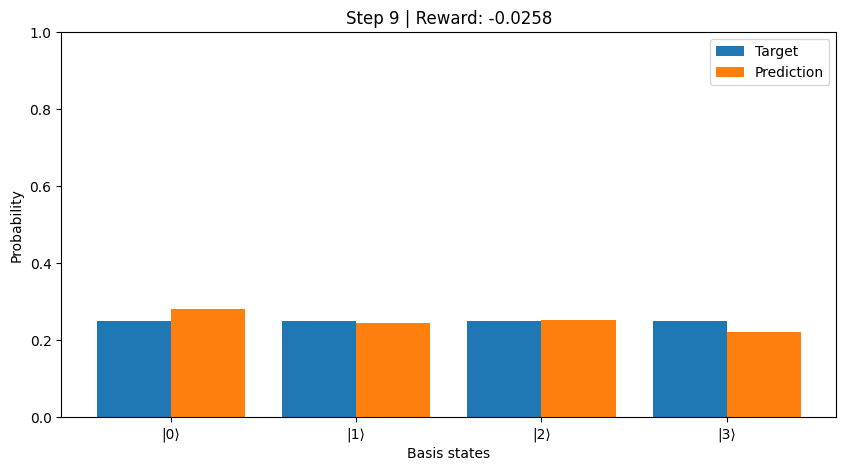

In [ ]:
from pennylane import numpy as np
import pennylane as qml
from qrl.env import ProbabilityV0

n_qubits = 2
target_distribution = np.array([0.25, 0.25, 0.25, 0.25])  # Example target distribution

# initialize environment
# set ffmpeg=True if you have ffmpeg installed to save as mp4, or ffmpeg=False to save as gif
env = ProbabilityV0(
    n_qubits=n_qubits,
    target_distribution=target_distribution,
    alpha=0.7,   # KL vs L2 weight
    beta=0.01,   # step penalty
    max_steps=10,
    ffmpeg=False
)

# Reset environment
params, _ = env.reset()


# Use PennyLane's optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.2)

# params = env.params.copy()
for step in range(env.max_steps):
    params, cost_val = opt.step_and_cost(env.cost_fn, params)
    probs = env.circuit(params)

    # Save history for rendering
    env.history.append(probs)
    env.params = params  # update env params
    reward = -cost_val
    env.rewards.append(-cost_val)
    print(f"Step {step}: Reward = {reward:.4f}")

    if reward > -1e-2:  # close to perfect
        break

# Animate the full evolution
env.render(save_path_without_extension="probability_v0")